In [94]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, interpolate
from scipy.ndimage import gaussian_filter1d
import seaborn as sns
from ADM import ADM
from scipy.fft import fft, fftfreq

from mutual_information import create_spectrogram

sns.set()

In [79]:
def reconstruct_from_spikes(spikes, length, spike_value, var=10):
    reconstructed_signal = np.zeros(length)
    spikes_sampling_rate_indices = (spikes * 64).astype(int)
    reconstructed_signal[spikes_sampling_rate_indices] = spike_value
    reconstructed_signal = gaussian_filter1d(reconstructed_signal, var)
    return reconstructed_signal

In [64]:
def loop_inplace_sum(arrlist):
    # assumes len(arrlist) > 0
    sum = arrlist[0].copy()
    for a in arrlist[1:]:
        sum += a
    return sum

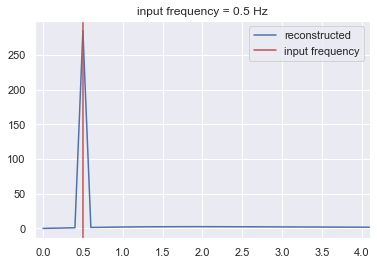

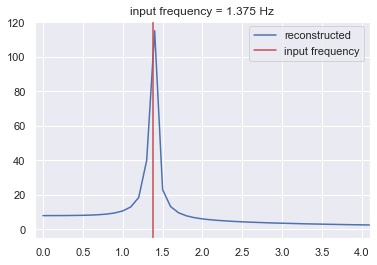

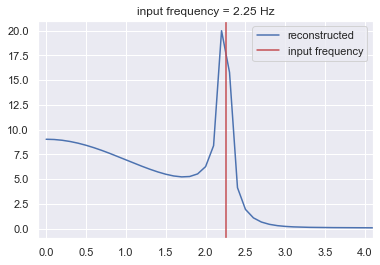

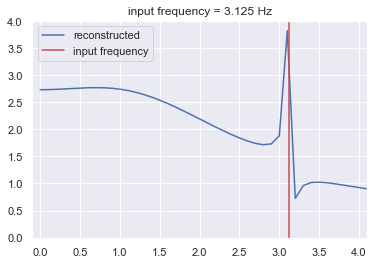

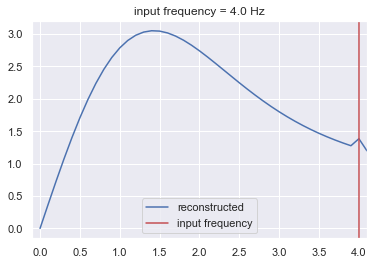

In [142]:
fs = 64 # hz
duration = 10 # s
signal_freqs = np.linspace(0.5, 4, 5)
threshold = 0.1
plot = True
var = 10

og_spectra = []
rec_spectra = []

for signal_freq in signal_freqs:
    input_signal = np.sin(np.arange(0, duration, 1 / fs) * signal_freq * 2 * np.pi)
    N = len(input_signal)

    up_spikes, down_spikes = ADM(
        input_signal,
        up_threshold=threshold,
        down_threshold=threshold,
        sampling_rate=fs,
        refractory_period=0
    )
    
    reconstructed_signal = (
        reconstruct_from_spikes(up_spikes, len(input_signal), 1, var) +
        reconstruct_from_spikes(down_spikes, len(input_signal), -1, var)
    )
    
    reconstructed_signal = gaussian_filter1d(input_signal, var)

    og_spectrum = abs(fft(input_signal)[:N//2])
    rec_spectrum = abs(fft(reconstructed_signal)[:N//2])
    freqs = fftfreq(N, 1 / fs)[:N//2]
    rec_spectra.append(rec_spectrum)
    og_spectra.append(og_spectrum)
    
    if plot:
        plt.title('input frequency = {} Hz'.format(signal_freq))
        plt.plot(freqs, rec_spectrum, label='reconstructed')
        plt.axvline(signal_freq, label='input frequency', color='r')
        plt.xlim(-0.1, 4.1)
        plt.legend()
        plt.show()
        #plt.plot(freqs, rec_spectrum / og_spectrum, label='transfer function')
        #plt.xlim(-1, 10)


(-1.0, 10.0)

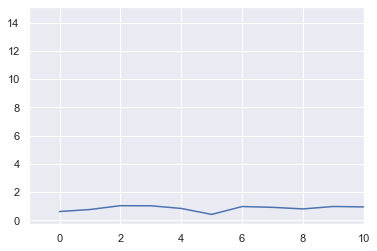

In [134]:
plt.plot(loop_inplace_sum(rec_spectra) / loop_inplace_sum(og_spectra))
plt.xlim(-1, 10)

<ipython-input-143-c98f4ac83731>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t_in, f_in, Sxx_in, shading='flat')


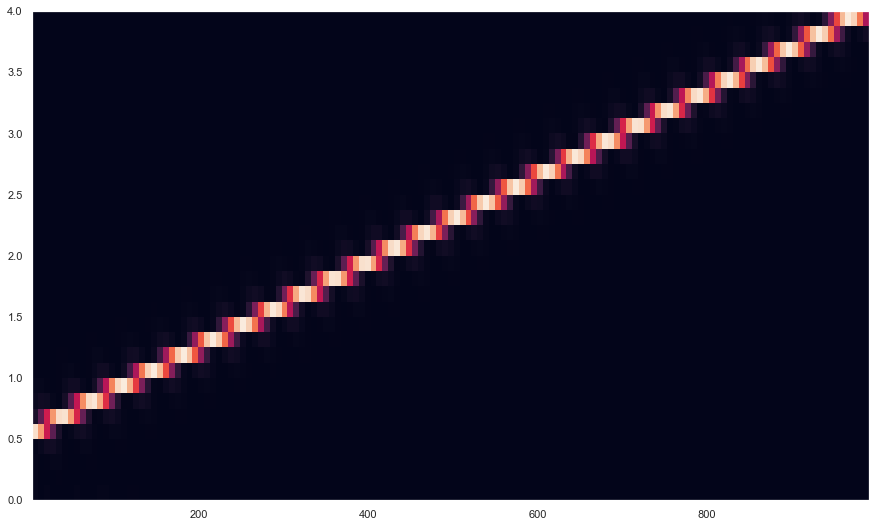

<ipython-input-143-c98f4ac83731>:29: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t_rec, f_rec, Sxx_rec, shading='flat')


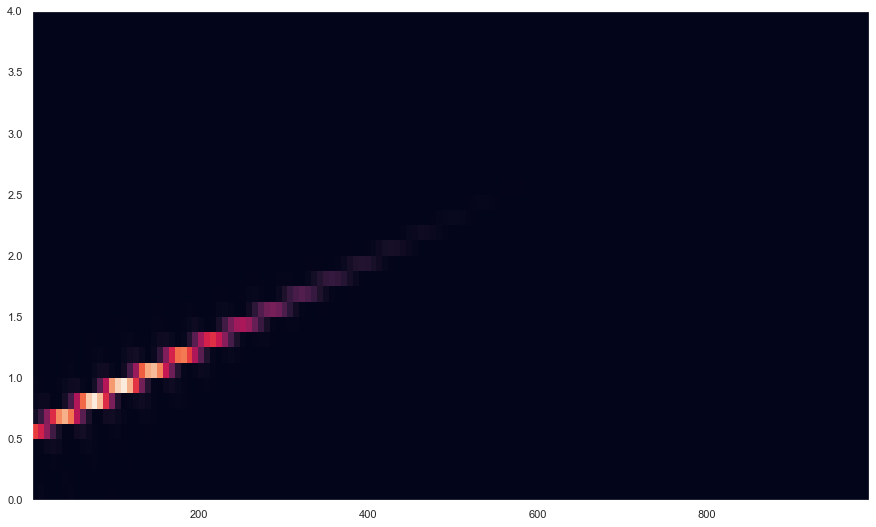

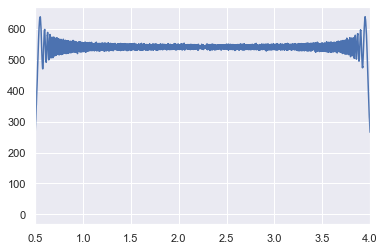

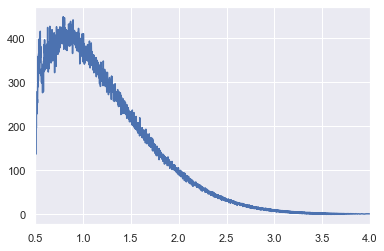

Text(0, 0.5, 'Output / input intensity')

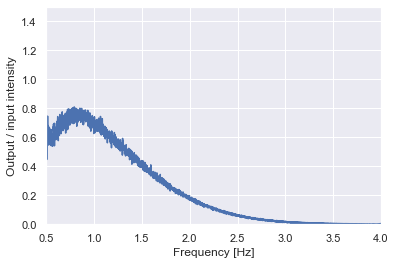

In [143]:
duration = 1000
threshold = 0.05
noise = np.random.normal(0, 0.1, size=duration * fs)
input_signal = signal.chirp(np.arange(0, duration, 1 / fs), f0=0.5, f1=4, t1=duration, method='linear') + 0.1 * noise
N = len(input_signal)
clip_percentile = 100
var = 10

f_in, t_in, Sxx_in = create_spectrogram(input_signal, 64, 512, None, fmin=0, fmax=4, clip_percentile=clip_percentile)
plt.figure(figsize=(15, 9))
plt.pcolormesh(t_in, f_in, Sxx_in, shading='flat')
plt.show()

up_spikes, down_spikes = ADM(
    input_signal,
    up_threshold=threshold,
    down_threshold=threshold,
    sampling_rate=fs,
    refractory_period=0
)

reconstructed_signal = (
    reconstruct_from_spikes(up_spikes, len(input_signal), 1, var) +
    reconstruct_from_spikes(down_spikes, len(input_signal), -1, var)
)

f_rec, t_rec, Sxx_rec = create_spectrogram(reconstructed_signal, 64 ,512, None, fmin=0, fmax=4, clip_percentile=clip_percentile)
plt.figure(figsize=(15, 9))
plt.pcolormesh(t_rec, f_rec, Sxx_rec, shading='flat')
plt.show()

og_intensities = abs(fft(input_signal)[:N//2])
rec_intensities = abs(fft(reconstructed_signal)[:N//2])
freqs = fftfreq(N, 1 / fs)[:N//2]

plt.plot(freqs, og_intensities, label='original')
plt.xlim(0.5, 4)
plt.show()
plt.plot(freqs, rec_intensities, label='reconstructed')
plt.xlim(0.5, 4)
plt.show()
plt.plot(freqs, rec_intensities / og_intensities, label='transfer function')
plt.xlim(0.5, 4)
plt.ylim(0, 1.5)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Output / input intensity')